# Capstone Project Title - Clustering of Medicare 2014 Part D Opioid claims to identify over prescribing providers

## Following is the path for Capstone proposal review

https://review.udacity.com/?utm_campaign=ret_000_auto_ndxxx_submission-reviewed&utm_source=blueshift&utm_medium=email&utm_content=reviewsapp-submission-reviewed&bsft_clkid=471d81a7-7756-4f74-889a-7556dc8c8f3e&bsft_uid=2857bd7e-7af1-428c-b23f-132d375237b3&bsft_mid=829e8efa-fa80-4931-a3ee-5ecb8b8faa32&bsft_eid=6f154690-7543-4582-9be7-e397af208dbd&bsft_txnid=66514290-0386-4f81-af11-dc31fdcdb6c0#!/reviews/1329182

## Source Data and other important links

Source of the 2014 medicare file. The following file contains 24121660 records which is huge, so will be pulling only the claims that have been submitted for an opioid drug
- https://data.cms.gov/Medicare-Part-D/Medicare-Provider-Utilization-and-Payment-Data-201/465c-49pb

Following is the pdf detailing about the columns in the dataset
- https://data.cms.gov/api/views/465c-49pb/files/0931bfc7-1069-4437-961b-e3f43e26ac33?download=true&filename=Part_D_Prescriber_PUF_Methodology_2017-05-25.pdf

Following is the list of drug classification, generic and branded names that are considered as Opioids. I have taken 2014 data
- https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/OpioidDrugList.zip

OIG exclusion list, list of providers identified as fradulent. Now please keep in mind that this exclusion list is for all types of frauds/misdiagnosis/malpractices not just Opioid over prescription. Goal is identify the list of providers who shall be further investigated. The list of providers should consist all of the providers from the list for which ever state we are doing clustering. 
- https://oig.hhs.gov/exclusions/exclusions_list.asp
- https://oig.hhs.gov/exclusions/downloadables/UPDATED.csv

Unix commands to grep the Opioid Claims data
    - Used grep to pull records per state, NY, CA, PA, AL. The first state to have records that my laptop could handle was AL
    - grep -f opioid_list.txt Medicare_Provider_Utilization_and_Payment_Data__2014_Part_D_Prescriber.csv > Opioid_Claims.csv
    - grep ',AL,' Medicare_Provider_Utilization_and_Payment_Data__2014_Part_D_Prescriber.csv > AL_Records.csv
    - for the above grep statement there is possibility that we will get records where the providers name or any other column other than state has AL value. We will delete these records later in the pandas dataframe

#### Before we proceed, please note that NPI stands for National Provider Identification. It is an intelligence free unique number assigned to all of the providers in the nation

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Pretty display for notebooks
%matplotlib inline
# Import supplementary visualizations code visuals.py, please note that this piece of code has been taken from 
# past udacity projects
import visuals as vs
import matplotlib.cm as cm

In [2]:
# Load the 2014 Opioid Claims Medicare Part D data
#data_orig_Opioid = pd.read_csv('Opioid_Claims.csv')

# Load the 2014 Opioid Claims Medicare Part D data for AL state, please note that my laptop could handle only AL data,
# python notebook crashed for NY, PA, and CA. So I went for the state where the medicaid membership is less than a 
# million in the year of 2014, the first state I hit was AL. So narrowed down on AL
data_orig_Opioid = pd.read_csv('AL_Records.csv')

/ML_Anaconda/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# check to see whether all columns have been imported
data_orig_Opioid.columns

Index([u'npi', u'nppes_provider_last_org_name', u'nppes_provider_first_name',
       u'nppes_provider_city', u'nppes_provider_state',
       u'specialty_description', u'description_flag', u'drug_name',
       u'generic_name', u'bene_count', u'total_claim_count',
       u'total_30_day_fill_count', u'total_day_supply', u'total_drug_cost',
       u'bene_count_ge65', u'bene_count_ge65_suppress_flag',
       u'total_claim_count_ge65', u'ge65_suppress_flag',
       u'total_30_day_fill_count_ge65', u'total_day_supply_ge65',
       u'total_drug_cost_ge65'],
      dtype='object')

In [4]:
# load the list of opioid drug generic name into a list
opioid_drugs = ['ACETAMINOPHEN WITH CODEINE','BUPRENORPHINE','BUPRENORPHINE HCL','BUTALBIT/ACETAMIN/CAFF/CODEINE',
                'BUTORPHANOL TARTRATE','CODEINE SULFATE','CODEINE/BUTALBITAL/ASA/CAFFEIN','CODEINE/CARISOPRODOL/ASPIRIN',
                'DHCODEINE BT/ACETAMINOPHN/CAFF','DIHYDROCODEINE/ASPIRIN/CAFFEIN','FENTANYL','FENTANYL CITRATE',
                'HYDROCODONE BITARTRATE','HYDROCODONE/ACETAMINOPHEN','HYDROCODONE/IBUPROFEN','HYDROMORPHONE HCL',
                'HYDROMORPHONE HCL/PF','IBUPROFEN/OXYCODONE HCL','LEVORPHANOL TARTRATE','MEPERIDINE HCL',
                'MEPERIDINE HCL/PF','METHADONE HCL','MORPHINE SULFATE','MORPHINE SULFATE/PF','NALBUPHINE HCL',
                'OPIUM TINCTURE','OPIUM/BELLADONNA ALKALOIDS','OXYCODONE HCL','OXYCODONE HCL/ACETAMINOPHEN',
                'OXYCODONE HCL/ASPIRIN','OXYMORPHONE HCL','PENTAZOCINE HCL/ACETAMINOPHEN','PENTAZOCINE HCL/NALOXONE HCL',
                'PENTAZOCINE LACTATE','TAPENTADOL HCL','TRAMADOL HCL','TRAMADOL HCL/ACETAMINOPHEN']

In [5]:
# get the records where the generic name is not in the opioid list, chances of unix code grep'ing an incorrect record
# data_orig_Opioid[~data_orig_Opioid.generic_name.isin(opioid_drugs)]
# data_orig_Opioid[pd.isnull(data_orig_Opioid['generic_name'])==True]

In [6]:
# We would like to keep only the records where claims have been billed for opioids
# data_orig_Opioid[data_orig_Opioid.generic_name.isin(opioid_drugs)] # 19316 rows × 21 columns

# Recollect that the part D claims data contain claims for drugs that are not opioids.
# so let us only pick the opioid claims
data_truely_opioids = data_orig_Opioid[data_orig_Opioid.generic_name.isin(opioid_drugs)]

In [7]:
# grep statement there is possibility that we will get records where the providers name or 
# any other column other than state has AL value. We will delete these records from the dataframe
data_truely_opioids = data_truely_opioids[data_truely_opioids['nppes_provider_state']=='AL']

In [8]:
# Some data cleaning up needs to be done, replace comma with null
# make sure that proper datatypes are assigned to columns
# I tried doing this unix but was cumbersome to use "SED", so i thought let me load it and deal wiht it in Dataframe
# when trying to assign datatypes to columns while importing data in to dataframe it failed becaus of the comma, so
# dealing with it after loading the data into dataframe

data_truely_opioids['bene_count'] = data_truely_opioids['bene_count'].str.replace(',', '')
data_truely_opioids['total_claim_count'] = data_truely_opioids['total_claim_count'].str.replace(',', '')
data_truely_opioids['total_day_supply'] = data_truely_opioids['total_day_supply'].str.replace(',', '')
data_truely_opioids['bene_count_ge65'] = data_truely_opioids['bene_count_ge65'].str.replace(',', '')
data_truely_opioids['total_claim_count_ge65'] = data_truely_opioids['total_claim_count_ge65'].str.replace(',', '')
data_truely_opioids['total_day_supply_ge65'] = data_truely_opioids['total_day_supply_ge65'].str.replace(',', '')

data_truely_opioids['bene_count'] = data_truely_opioids.bene_count.astype(float)
data_truely_opioids['total_claim_count'] = data_truely_opioids.total_claim_count.astype(float)
data_truely_opioids['total_day_supply'] = data_truely_opioids.total_day_supply.astype(float)
data_truely_opioids['bene_count_ge65'] = data_truely_opioids.bene_count_ge65.astype(float)
data_truely_opioids['total_claim_count_ge65'] = data_truely_opioids.total_claim_count_ge65.astype(float)
data_truely_opioids['total_day_supply_ge65'] = data_truely_opioids.total_day_supply_ge65.astype(float)

data_truely_opioids['total_30_day_fill_count'] = data_truely_opioids['total_30_day_fill_count'].str.replace(',', '')
data_truely_opioids['total_drug_cost'] = data_truely_opioids['total_drug_cost'].str.replace(',', '')
data_truely_opioids['total_drug_cost_ge65'] = data_truely_opioids['total_drug_cost_ge65'].str.replace(',', '')
data_truely_opioids['total_30_day_fill_count_ge65'] = data_truely_opioids['total_30_day_fill_count_ge65'].str.replace(',', '')

data_truely_opioids['total_30_day_fill_count'] = data_truely_opioids.total_30_day_fill_count.astype(float)
data_truely_opioids['total_drug_cost'] = data_truely_opioids.total_drug_cost.astype(float)
data_truely_opioids['total_drug_cost_ge65'] = data_truely_opioids.total_drug_cost_ge65.astype(float)
data_truely_opioids['total_30_day_fill_count_ge65'] = data_truely_opioids.total_30_day_fill_count_ge65.astype(float)

# Please note that although NPI is a numberic value, this is used to identify a provider, so it is better we convert 
# this column to a string
# data_truely_opioids['npi'] = data_truely_opioids.npi.astype(object)

In general Medicare is for elderly population 65 or above 65, we can disregard the columns where data is indicated for 65 or above 65 beneficiaries. Medicare is also utilized by some eligible low income families and newborns but this population is less when compared to the 65 and above population. And in general opioids should be precribed for adults. So wiht these assumptions we are eliminating the columns where data is specifically mentioned for 65 and above population.

In [9]:
# Drop the flag columns which are not needed for our analysis.
data_truely_opioids = data_truely_opioids.drop(['nppes_provider_last_org_name','nppes_provider_first_name',
                                                'nppes_provider_city','description_flag','drug_name',
                                                'bene_count_ge65_suppress_flag','ge65_suppress_flag',
                                                'nppes_provider_state','specialty_description','bene_count_ge65',
                                                'total_claim_count_ge65','total_30_day_fill_count_ge65',
                                                'total_day_supply_ge65','total_drug_cost_ge65'],axis=1)

Fill NaN values with 5, rather using sklearn.preprocessing "Imputer", taken from the pdf detailing about the columns in the dataset. Following is the copy past of the column desriptions when read are self explanatory as to why i choose 5. This is mid value between 1 and 10(or 11, using 5.5 does not make sense so took the lower side). Please read through patiently. 
 - https://data.cms.gov/api/views/465c-49pb/files/0931bfc7-1069-4437-961b-e3f43e26ac33?download=true&filename=Part_D_Prescriber_PUF_Methodology_2017-05-25.pdf

 - bene_count – The total number of unique Medicare Part D beneficiaries with at least one claim for the drug. Counts fewer than 11 are suppressed and are indicated by a blank.
 - total_claim_count – The number of Medicare Part D claims. This includes original prescriptions and refills. Aggregated records based on total_claim_count fewer than 11 are not included in the data file.
 - total_30_day_fill_count – The aggregate number of Medicare Part D standardized 30-day fills. The standardized 30-day fill is derived from the number of days supplied on each Part D claim divided by 30. Standardized 30-day fill values less than 1.0 were bottom-coded with a value of 1.0 and standardized 30- day fill values greater than 12.0 were top-coded with a value of 12.0.
 - bene_count_ge65_suppress_flag – A flag indicating the reason the bene_count_ge65 variable is suppressed.
     - “*” = Primary suppressed due to bene_count_ge65 between 1 and 10.
     - “#” = Counter suppressed because the “less than 65 year old” group (not explicitly displayed) contains a beneficiary count between 1 and 10, which can be mathematically determined from bene_count_ge65 and bene_count.
 - ge65_suppress_flag – A flag that indicates the reason the total_claim_count_ge65, total_30_day_fill_count ge65, total_day_supply_ge65, and total_drug_cost_ge65 variables are suppressed.
     - “*” = Primary suppressed due to total_claim_count_ge65 between 1 and 10.
     - “#” = Counter suppressed because the “less than 65 year old” group (not explicitly displayed) contains a small claim count between 1 and 10, which can be mathematically determined from the total_claim_count_ge65 and total_claim_count.
 - total_30_day_fill_count_ge65 – The number of Medicare Part D standardized 30-day fills for beneficiaries age 65 and older. The standardized 30-day fill is derived from the number of days supplied on each Part D claim divided by 30. Standardized 30-day fill values less than 1.0 were bottom-coded with a value of 1.0 and standardized 30-day fill values greater than 12.0 were top-coded with a value of 12.0. If total_claim_count_ge65 is suppressed, this variable is suppressed. A blank indicates the value is suppressed. See ge65_suppress_flag regarding suppression of data.

In [10]:
# Took the mid value between of - bene_count – 
# The total number of unique Medicare Part D beneficiaries with at least one claim for the drug. Counts fewer than 
# 11 are suppressed and are indicated by a blank. Count of humans cannot be 5.5 so took 5
data_truely_opioids = data_truely_opioids.fillna(value=5)

## Data Exploration

Let us do some data exploration to find out whether we would need preprocessing of data. We can also try to figure out some useful information

In [11]:
data_truely_opioids.describe()

,npi,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
count,1.927200e+04,19272.000000,19272.000000,19272.000000,19272.000000,1.927200e+04
mean,1.496169e+09,7.217570,113.373391,116.354203,2631.379255,4.729395e+03
std,2.864603e+08,17.241966,278.278762,282.224123,7462.863382,2.632810e+04
min,1.003012e+09,5.000000,11.000000,11.000000,16.000000,2.410000e+01
25%,1.245239e+09,5.000000,18.000000,18.000000,289.000000,2.551550e+02
50%,1.497753e+09,5.000000,36.000000,36.000000,604.000000,8.254350e+02
75%,1.740415e+09,5.000000,94.000000,97.000000,1830.000000,3.011185e+03
max,1.992997e+09,920.000000,6955.000000,6970.400000,197327.000000,2.428956e+06


Analysis notes

- Looking at the Min, Max, 50%, std and the Mean values none of the columns seem to have normal distribution.
- To certain extent total_drug_cost has some distribution of data that might be closer to normal distribution.
- The bene_count is kind of screwed up, looks like there are many NaN values and we have replaced them with 5.

In [12]:
# A single NPI (provider) can prescribe multiple generic Opioids, so we group the claims by NPI
# Please note that NPI stands for National Provider Identification. It is an intelligence free unique 
# number assigned to each provider in the nation
data_grouped_npi = data_truely_opioids.groupby(['npi'])

In [13]:
# Let us now take data aggregated by NPI, so that the data is indexed against the NPIs
data_aggr_npi = data_grouped_npi.sum()

In [14]:
data_aggr_npi.describe()

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
count,6742.000000,6742.000000,6742.000000,6742.000000,6.742000e+03
mean,20.631415,324.077722,332.598368,7521.794868,1.351897e+04
std,36.933638,833.783656,844.618870,22430.030373,9.354357e+04
min,5.000000,11.000000,11.000000,16.000000,2.410000e+01
25%,5.000000,28.000000,28.000000,188.000000,2.125900e+02
50%,10.000000,77.000000,79.000000,713.500000,7.304150e+02
75%,20.000000,272.000000,282.475000,4950.000000,4.542587e+03
max,1024.000000,26391.000000,26426.900000,579336.000000,5.385210e+06


Analysis Notes

- To certain extent the data looks better now, but looks like some preprocessing such as feature scaling has to be done on the data becasue of the huge variance in data across the columns
- The record count are reached to a point where I think my laptop can handle :)

## Let us try to take some samples here, let us have some fraud providers in the sample

Just doing a google of providers charged with opioid prescription, we will get a list of providers
https://www.justice.gov/usao-sdal/pr/dr-couch-and-dr-ruan-sentenced-240-and-252-months-federal-prison-running-massive-pill

The NPI numbers of the two providers are 1053372201,1023079274

In [15]:
#data_aggr_npi[(data_aggr_npi['bene_count'] == 1024)]
#data_aggr_npi[(data_aggr_npi['bene_count'] == 669)]
#data_aggr_npi[(data_aggr_npi['total_claim_count'] == 26391)]
#data_aggr_npi[(data_aggr_npi['total_claim_count'] == 8492)]
#data_aggr_npi[data_aggr_npi['total_drug_cost']==5385210.2699999996]

In [16]:
# Let us take an example of provider where the total drug cost is least in the data set
data_aggr_npi[data_aggr_npi['total_drug_cost']==24.1]
#data_aggr_npi[data_aggr_npi['total_drug_cost']==17.42]

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
npi,,,,,
1417967688,11.0,11.0,11.0,16.0,24.1


In [17]:
data_aggr_npi.loc[[1053372201,1023079274,1417967688]]
#data_aggr_npi.loc[[1417967688,1326019712,1851380984]]
#data_aggr_npi.loc[[1295845584,1316942022,1962426148]]

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
npi,,,,,
1053372201,149.0,19905.0,20061.8,579336.0,5385210.27
1023079274,457.0,13659.0,13741.4,398378.0,2698514.25
1417967688,11.0,11.0,11.0,16.0,24.10


In [18]:
# Let us put the data into samples table
#samples = data_aggr_npi.loc[[1295845584,1316942022,1962426148]]
samples = data_aggr_npi.loc[[1053372201,1023079274,1417967688]]

In [19]:
samples

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
npi,,,,,
1053372201,149.0,19905.0,20061.8,579336.0,5385210.27
1023079274,457.0,13659.0,13741.4,398378.0,2698514.25
1417967688,11.0,11.0,11.0,16.0,24.10


## Visualize Feature Distributions

/ML_Anaconda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


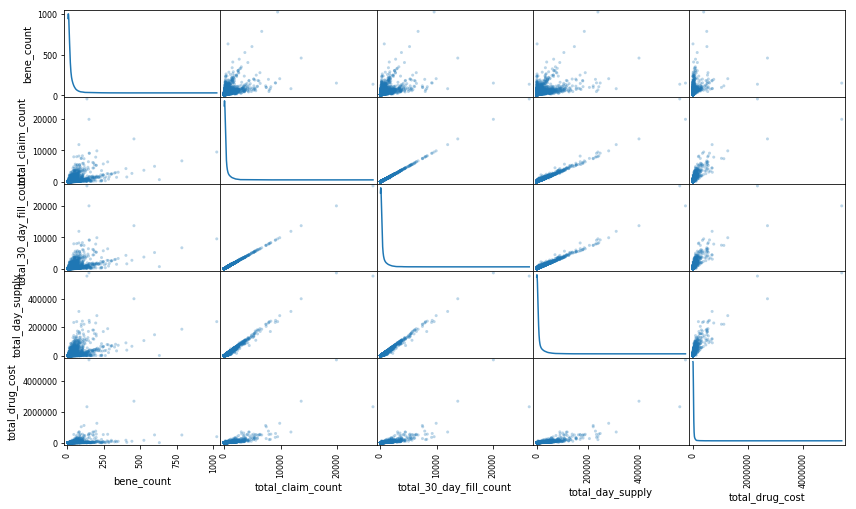

In [20]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data_aggr_npi, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

Analysis Notes

- Looks like features such as total_30_day_fill_count, total_day_supply are closely related in terms of data pattern/trend. This makes sense because because total_30_day_fill_count is derived from total_day_supply
- The next set of columns closely reated are the bene_count and total_claim_count. Again makes sense becasue in general as the beneficiaries increase the claim count increases.
- We can notice that there is an over all trend as the feature values increase. Even the total_drug_cost shows a minor trend.
- We have not done preprocessing of features so we will not be able to see some kind of distribution of data.
- Like stated early the variance, std, min and max shows that data spread from the mean is huge on both sides of mean, this has to be reduce by perfroming data preprocessing, specifically feature scaling

## Data Preprocessing

#### Feature Scaling - because data seems to skewed, like stated in above comments

In [21]:
# apply log to reduce the data spread
data_log = np.log(data_aggr_npi)
samples_log = np.log(samples)

In [22]:
data_log.describe()

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
count,6742.000000,6742.000000,6742.000000,6742.000000,6742.000000
mean,2.473064,4.550381,4.573162,6.903659,6.992768
std,0.922078,1.491559,1.498594,2.059728,2.073895
min,1.609438,2.397895,2.397895,2.772589,3.182212
25%,1.609438,3.332205,3.332205,5.236442,5.359365
50%,2.302585,4.343805,4.369448,6.570182,6.593613
75%,2.995732,5.605802,5.643590,8.507143,8.421252
max,6.931472,10.180778,10.182138,13.269638,15.499167


In [23]:
samples_log.describe()

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,4.508842,7.272925,7.277546,9.645794,11.163197
std,1.912089,4.226096,4.230134,5.955315,6.920365
min,2.397895,2.397895,2.397895,2.772589,3.182212
25%,3.700921,5.960025,5.963032,7.833873,8.995212
50%,5.003946,9.522154,9.528168,12.895157,14.808212
75%,5.564315,9.710440,9.717371,13.082397,15.153689
max,6.124683,9.898726,9.906573,13.269638,15.499167


Data spread is reduced to a large extent, let us do a scatter plot and see how data looks like now.

/ML_Anaconda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


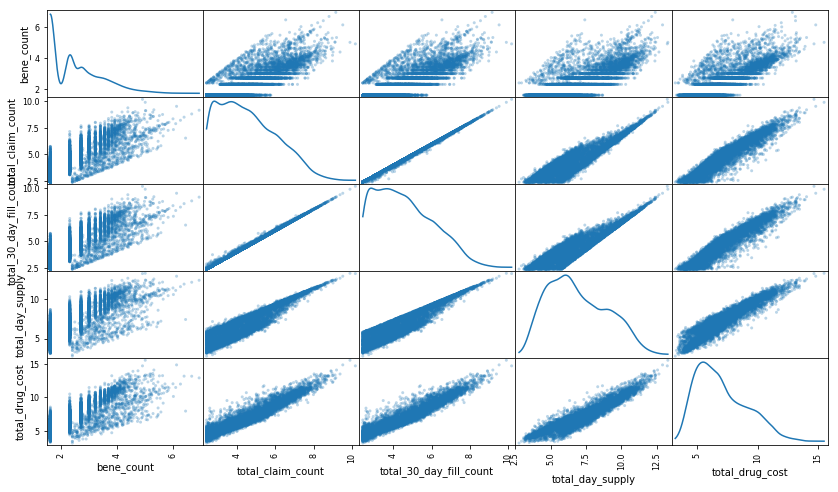

In [24]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data_log, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

- If we look at the plot, looks like we have acheived a somewhat good data structure, the total_drug_cost seems to be normally distributed data.
- We should not be performing outlier detection on this data, because there is a high probability that providers submitting high volumes of claims would be on the upper outliers and we would end loosing key data

In [25]:
# a qucik check to see whether indexes are retained, here index is the NPI.
data_log.index

Int64Index([1003011859, 1003014762, 1003024746, 1003086521, 1003100694,
            1003105719, 1003132200, 1003800046, 1003801432, 1003802885,
            ...
            1992910467, 1992934780, 1992936876, 1992949135, 1992950158,
            1992962856, 1992964860, 1992966261, 1992968291, 1992997415],
           dtype='int64', name=u'npi', length=6742)

## Feature Transformation

We will use principal component analysis (PCA) to see what combination of features/columns best represents the underlying data structure. We will start with 2 dimensions and later see what is the explained variance ratio of each dimension. Let us examine the total variance to see whether the pca components were able to completely represent the data. Later on proceed to what is the best value for pca component by combining this with silhouette_score.

Before we proceed we will have to ask this question, do we need to do PCA here? If we look at the data, we will notice that almost all the features are related with each other. The total_claim_count is proportional to the bene_count, the rest of the features total_30_day_fill_count, total_day_supply and total_drug_cost are all proportional to total_claim_count. The more the total_claim_count the more the rest of the columns. In general PCA is use to reduce the number of features but here even though we do not have many features we shall use it to combine the features which would represent the complete data. This way we will end up with features that are independent of each other.

In [26]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the data with only two dimensions
pca = PCA(n_components=2, whiten=True).fit(data_log)

# Transform the data using the PCA fit above
pca_data = pca.transform(data_log)
pca_samples = pca.transform(samples_log)

# Create a DataFrame for the reduced data
pca_data = pd.DataFrame(pca_data, columns = ['Dimension 1', 'Dimension 2'])

In [27]:
#check to see whether we have the NPI indexes still on the data
pca_data.head(5)

,Dimension 1,Dimension 2
0,-0.936758,-0.360447
1,-1.011638,0.573178
2,-0.279692,-0.053992
3,0.834102,0.296489
4,-0.180193,-1.403034


In [28]:
pca.explained_variance_ratio_

array([ 0.94190322,  0.02476521])

Looks like the first dimension that Dimension 1 itself represents the whole of the data. Let us take a look at the dimensions to see what features they represent.

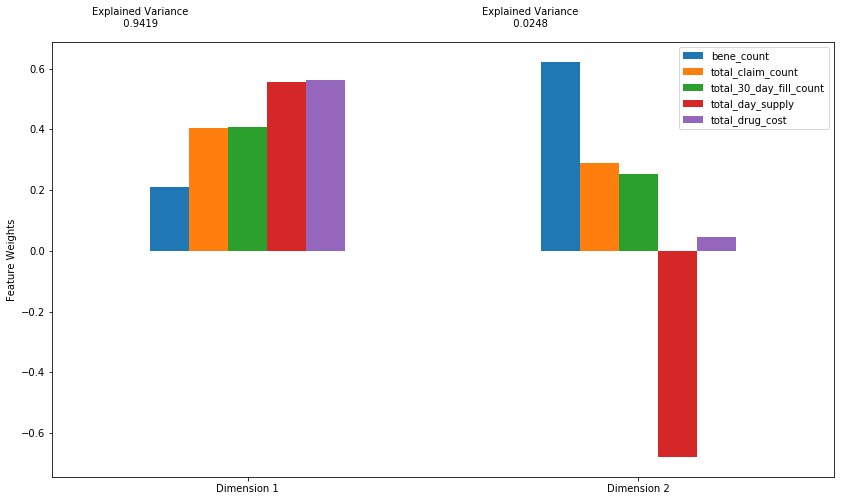

In [29]:
# Generate PCA results plot
pca_results = vs.pca_results(data_log, pca)

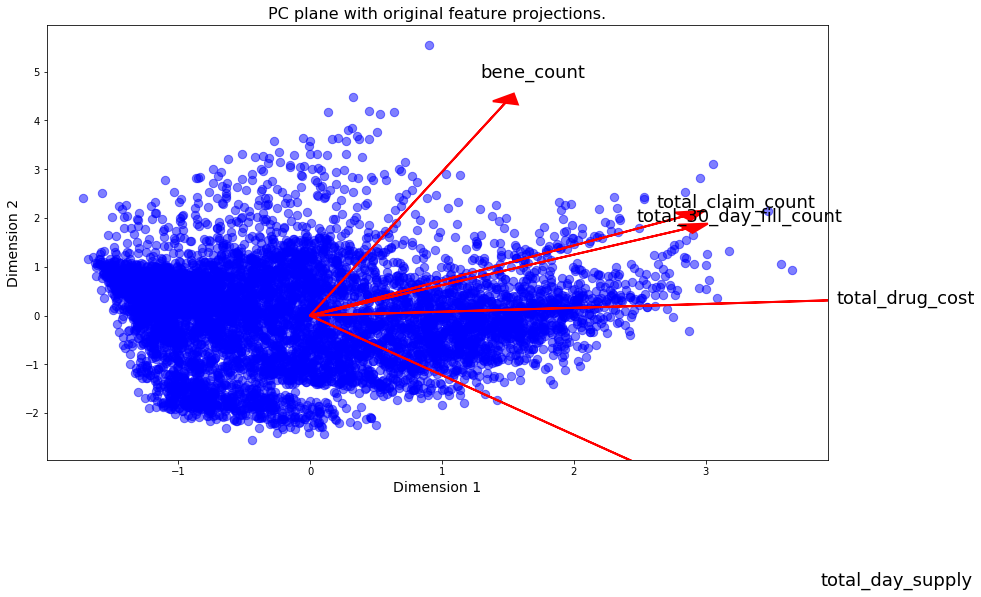

In [30]:
# Create a biplot
vs.biplot(data_log, pca_data, pca)

I have stated earlier that total_30_day_fill_count, total_day_supply, but I was wrong. Looking at the biplot it shows that total_claim_count and total_30_day_fill_count are closely related. 

## Clustering

#### Benchmark model

There might be several of models that have been developed since I am using 2014 CMS data and since CMS itself came up with models in 2010 to identify the fraudulent providers. The office of inspector general of department of Health and Human Services has come up with list of excluded providers, this is called exclusion list.  Now please keep in mind that this exclusion list is for all types of frauds/misdiagnosis/malpractices not just Opioid over prescription. Goal is identify the list of providers who shall be further investigated. 
OIG exclusion list, list of providers identified as fraudulent
https://oig.hhs.gov/exclusions/exclusions_list.asp
https://oig.hhs.gov/exclusions/downloadables/UPDATED.csv

Let us still build some base model so that we can use to benchmark over model against the benchmark model

In [31]:
from sklearn.cluster import MeanShift, estimate_bandwidth    

ms = MeanShift()
ms.fit(pca_data)
preds = ms.labels_
centers = ms.cluster_centers_

visuals.py:70: RuntimeWarning: invalid value encountered in double_scalars
  color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);


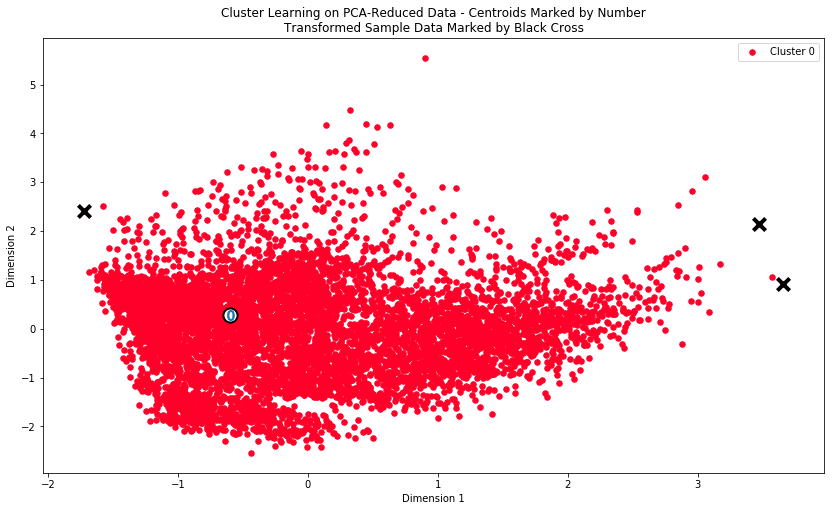

In [32]:
vs.cluster_results(pca_data,preds,centers,pca_samples)

##### Please note for us to generate silhouette_score for the benchmark model it is not possible because the Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Here i would like to see clustering done by 3 different algorithms. I would prefer hard clustering than soft clustering the reason being we do not want to have a provider who should be investigated and still be considered as not fradulent. 

I am going to playaround with multiple algorithms and then multiple clusters to see which combination has highest silhouette_score 

In [33]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score


for k in range(2,16):
    # Apply clustering algorithm to the reduced data 
    #clusterer = GaussianMixture(n_components=k, random_state=0)
    clusterer = KMeans(n_clusters=k, random_state=0)
    #clusterer = MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=100, n_init=10, max_no_improvement=10,
    #                            verbose=0)
    clusterer.fit(pca_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(pca_data)

    # Find the cluster centers
    #centers = clusterer.means_
    centers = clusterer.cluster_centers_

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(pca_data,preds)
    print k, score

2 0.372287719422
3 0.427982178823
4 0.409257396764
5 0.379875984737
6 0.367649497255
7 0.371656096879
8 0.364709945707
9 0.364345160191
10 0.3679749399
11 0.372942817412
12 0.349841330207
13 0.354247610097
14 0.355070406379
15 0.353588281612


In [34]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

for k in range(2,16):
    # Apply clustering algorithm to the reduced data 
    clusterer = GaussianMixture(n_components=k, random_state=0)
    clusterer.fit(pca_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(pca_data)

    # Find the cluster centers
    centers = clusterer.means_

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(pca_data,preds)
    print k, score

2 0.367350016839
3 0.40730698762
4 0.337421537882
5 0.32368526058
6 0.301453166511
7 0.360395915251
8 0.353739212133
9 0.341598022882
10 0.355758688181
11 0.365903412119
12 0.356720850043
13 0.357291442915
14 0.345563262781
15 0.349558589395


In [35]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score


for k in range(2,16):
    # Apply clustering algorithm to the reduced data 
    clusterer = MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=100, n_init=10, max_no_improvement=10,
                                verbose=0)
    clusterer.fit(pca_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(pca_data)

    # Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(pca_data,preds)
    print k, score

2 0.37256132741
3 0.427757220652
4 0.385420843355
5 0.382261894873
6 0.368934282306
7 0.361625662514
8 0.321922419869
9 0.351114849336
10 0.358469455936
11 0.341163048169
12 0.341227262597
13 0.35511450334
14 0.33193482689
15 0.32218205434


I have done this manually which is kind of tedious so I shall try to put it in data frame and pick the combination which has max silhouette_score. I wanted to add the explanied variance for all the dimensions, but that will be more cumbursome, so selecting the total explained variance for first two dimensions

### Please note that the following piece of code takes about 10 mins to complete.

In [36]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

col_names =  ['pca_dimensions', 'explained_variance_first2dims','Algorithm_name', 'numberof_cluster','silhouette_score']
SearchForMaxSilhouette  = pd.DataFrame(columns = col_names)

for pca_components in range(2,6):
    # Apply PCA by fitting the data with only two dimensions
    pca = PCA(n_components=pca_components, whiten=True).fit(data_log)
    
    # Transform the data using the PCA fit above
    pca_data = pca.transform(data_log)
    
    # dimensions for the data frame
    column_names = []
    for i in range(1, pca_components+1):
        column_names.append('Dimension'+str(i))
    
    # Create a DataFrame for the reduced data
    pca_data = pd.DataFrame(pca_data, columns = column_names)
    
    #print 'For '+str(pca_components)+' pca_components following are the clusters and their silhouette_score' 
    
    # calculate the total explained variance of the first 2 dimensions
    explained_variance_first2dims=0
    explained_variance_first2dims=pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]
    
    for k in range(2,16):
        # Apply clustering algorithm to the reduced data 
        clustering_algo = ['GaussianMixture','KMeans','MiniBatchKMeans']
        for i in range(0,len(clustering_algo)):
            if clustering_algo[i] == 'GaussianMixture':
                clusterer = GaussianMixture(n_components=k, random_state=0)
                # fit the dat
                clusterer.fit(pca_data)
                # Predict the cluster for each data point
                preds = clusterer.predict(pca_data)
                # Calculate the mean silhouette coefficient for the number of clusters chosen
                score = silhouette_score(pca_data,preds)
                #print 'For '+str(pca_components)+' pca_components and '+str(k)+' clusters of GaussianMixture the silhouette_score is '+str(score)
                SearchForMaxSilhouette.loc[len(SearchForMaxSilhouette)] = [pca_components,explained_variance_first2dims,'GaussianMixture',k,score]
            elif clustering_algo[i] == 'KMeans':
                clusterer = KMeans(n_clusters=k, random_state=0)
                # fit the dat
                clusterer.fit(pca_data)
                # Predict the cluster for each data point
                preds = clusterer.predict(pca_data)
                # Calculate the mean silhouette coefficient for the number of clusters chosen
                score = silhouette_score(pca_data,preds)
                #print 'For '+str(pca_components)+' pca_components and '+str(k)+' clusters of KMeans the silhouette_score is '+str(score)
                SearchForMaxSilhouette.loc[len(SearchForMaxSilhouette)] = [pca_components,explained_variance_first2dims,'KMeans',k,score]
            else:
                clusterer = MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=100,n_init=10, max_no_improvement=10,verbose=0)
                # fit the dat
                clusterer.fit(pca_data)
                # Predict the cluster for each data point
                preds = clusterer.predict(pca_data)
                # Calculate the mean silhouette coefficient for the number of clusters chosen
                score = silhouette_score(pca_data,preds)
                #print 'For '+str(pca_components)+' pca_components and '+str(k)+' clusters of MiniBatchKMeans the silhouette_score is '+str(score)
                SearchForMaxSilhouette.loc[len(SearchForMaxSilhouette)] = [pca_components,explained_variance_first2dims,'MiniBatchKMeans',k,score]

In [37]:
print np.round(max(SearchForMaxSilhouette['silhouette_score']),decimals=9)
print max(SearchForMaxSilhouette['silhouette_score'])
print max(SearchForMaxSilhouette['explained_variance_first2dims'])
print np.round(max(SearchForMaxSilhouette['explained_variance_first2dims']), decimals=9)

0.427982179
0.427982178823
0.966668435905
0.966668436


In [38]:
SearchForMaxSilhouette[np.round(SearchForMaxSilhouette['silhouette_score'],decimals=9)==
                       np.round(max(SearchForMaxSilhouette['silhouette_score']),decimals=9)]

,pca_dimensions,explained_variance_first2dims,Algorithm_name,numberof_cluster,silhouette_score
4,2,0.966668,KMeans,3,0.427982


In [39]:
SearchForMaxSilhouette[np.round(SearchForMaxSilhouette['explained_variance_first2dims'],decimals=9)==
                       np.round(max(SearchForMaxSilhouette['explained_variance_first2dims']),decimals=9)]

,pca_dimensions,explained_variance_first2dims,Algorithm_name,numberof_cluster,silhouette_score
0,2,0.966668,GaussianMixture,2,0.367350
1,2,0.966668,KMeans,2,0.372288
2,2,0.966668,MiniBatchKMeans,2,0.372250
3,2,0.966668,GaussianMixture,3,0.407307
4,2,0.966668,KMeans,3,0.427982
5,2,0.966668,MiniBatchKMeans,3,0.425277
6,2,0.966668,GaussianMixture,4,0.337422
7,2,0.966668,KMeans,4,0.409257
8,2,0.966668,MiniBatchKMeans,4,0.407683
9,2,0.966668,GaussianMixture,5,0.323685


In [40]:
SearchForMaxSilhouette[
    (np.round(SearchForMaxSilhouette['silhouette_score'],decimals=9)==
                       np.round(max(SearchForMaxSilhouette['silhouette_score']),decimals=9))
    &
    (np.round(SearchForMaxSilhouette['explained_variance_first2dims'],decimals=9)==
                       np.round(max(SearchForMaxSilhouette['explained_variance_first2dims']),decimals=9))
]

,pca_dimensions,explained_variance_first2dims,Algorithm_name,numberof_cluster,silhouette_score
4,2,0.966668,KMeans,3,0.427982


So we have determined that 2 PCA dimensions and 3 cluster for Kmeans algorithm we get the max silhouette_score, from the combinations that we pre-selected

In [41]:
# Apply PCA by fitting the data with only two dimensions
pca = PCA(n_components=2, whiten=True).fit(data_log)

# Transform the data using the PCA fit above
pca_data = pca.transform(data_log)
pca_samples = pca.transform(samples_log)

# Create a DataFrame for the reduced data
pca_data = pd.DataFrame(pca_data, columns = ['Dimension 1', 'Dimension 2'])

# Clustering
clusterer = KMeans(n_clusters=3, random_state=0)
clusterer.fit(pca_data)
preds = clusterer.predict(pca_data)
centers = clusterer.cluster_centers_

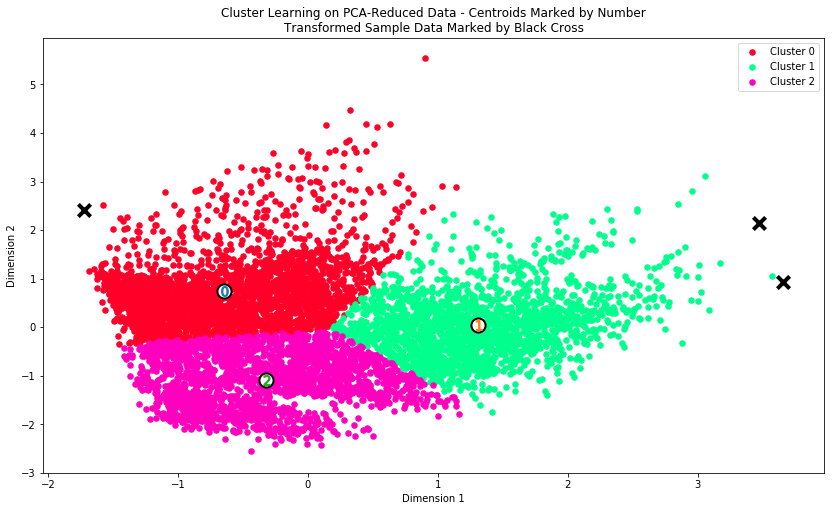

In [42]:
# Display the results of the clustering from implementation
vs.cluster_results(pca_data,preds,centers,pca_samples)

Assuming that we do not what are fradulent and what are good NPIs, let try to get total Samples for each cluster

In [43]:
print len(preds[preds==0])
print len(preds[preds==1])
print len(preds[preds==2])

2812
1892
2038


Now if we notice we will see that cluster number 1 is of smaller size, so I would pick that one as my investigation list. The other way of doing this is to get the aggregate total_drug_cost and aggregate other columns and see which one is having the highest per NPI in the cluster and take that cluster for further investigation

Now for us to see the aggregrated data, we need to recover the data to its original value. So let us do that

#### Model Evaluation and Validation

Let us see how this model performs on unseen data, such dataset from other state claims

In [44]:
#Load data for another state, let us say PA
data_orig_PA = pd.read_csv('PA_Records.csv')

#Make sure you keep only the opioid claims
data_truely_PA = data_orig_PA[data_orig_PA.generic_name.isin(opioid_drugs)]

#Make sure to have only claims from PA state
data_truely_PA = data_truely_PA[data_truely_PA['nppes_provider_state']=='PA']

#Data Clean Up
data_truely_PA['bene_count'] = data_truely_PA['bene_count'].str.replace(',', '')
data_truely_PA['total_claim_count'] = data_truely_PA['total_claim_count'].str.replace(',', '')
data_truely_PA['total_day_supply'] = data_truely_PA['total_day_supply'].str.replace(',', '')
data_truely_PA['bene_count_ge65'] = data_truely_PA['bene_count_ge65'].str.replace(',', '')
data_truely_PA['total_claim_count_ge65'] = data_truely_PA['total_claim_count_ge65'].str.replace(',', '')
data_truely_PA['total_day_supply_ge65'] = data_truely_PA['total_day_supply_ge65'].str.replace(',', '')

data_truely_PA['bene_count'] = data_truely_PA.bene_count.astype(float)
data_truely_PA['total_claim_count'] = data_truely_PA.total_claim_count.astype(float)
data_truely_PA['total_day_supply'] = data_truely_PA.total_day_supply.astype(float)
data_truely_PA['bene_count_ge65'] = data_truely_PA.bene_count_ge65.astype(float)
data_truely_PA['total_claim_count_ge65'] = data_truely_PA.total_claim_count_ge65.astype(float)
data_truely_PA['total_day_supply_ge65'] = data_truely_PA.total_day_supply_ge65.astype(float)

data_truely_PA['total_30_day_fill_count'] = data_truely_PA['total_30_day_fill_count'].str.replace(',', '')
data_truely_PA['total_drug_cost'] = data_truely_PA['total_drug_cost'].str.replace(',', '')
data_truely_PA['total_drug_cost_ge65'] = data_truely_PA['total_drug_cost_ge65'].str.replace(',', '')
data_truely_PA['total_30_day_fill_count_ge65'] = data_truely_PA['total_30_day_fill_count_ge65'].str.replace(',', '')

data_truely_PA['total_30_day_fill_count'] = data_truely_PA.total_30_day_fill_count.astype(float)
data_truely_PA['total_drug_cost'] = data_truely_PA.total_drug_cost.astype(float)
data_truely_PA['total_drug_cost_ge65'] = data_truely_PA.total_drug_cost_ge65.astype(float)
data_truely_PA['total_30_day_fill_count_ge65'] = data_truely_PA.total_30_day_fill_count_ge65.astype(float)

# Drop the flag columns which are not needed for our analysis.
data_truely_PA = data_truely_PA.drop(['nppes_provider_last_org_name','nppes_provider_first_name',
                                                'nppes_provider_city','description_flag','drug_name',
                                                'bene_count_ge65_suppress_flag','ge65_suppress_flag',
                                                'nppes_provider_state','specialty_description','bene_count_ge65',
                                                'total_claim_count_ge65','total_30_day_fill_count_ge65',
                                                'total_day_supply_ge65','total_drug_cost_ge65'],axis=1)

# data fill NaN
data_truely_PA = data_truely_PA.fillna(value=5)

#Group by NPI
data_grouped_PA = data_truely_PA.groupby(['npi'])
# Let us now take data aggregated by NPI, so that the data is indexed against the NPIs
data_grouped_PA = data_grouped_PA.sum()

In [45]:
#JOHN CHERIAN 1134381593
# Following are prosecuted based on the below link PETER JAMES RIDELLA MD 1124015797, RUTH D JONES 1750420303, 
#https://www.justice.gov/usao-wdpa/pr/western-district-pennsylvania-participated-largest-health-care-fraud-enforcement-action
samples_PA=data_grouped_PA.loc[[1134381593,1124015797,1750420303]]

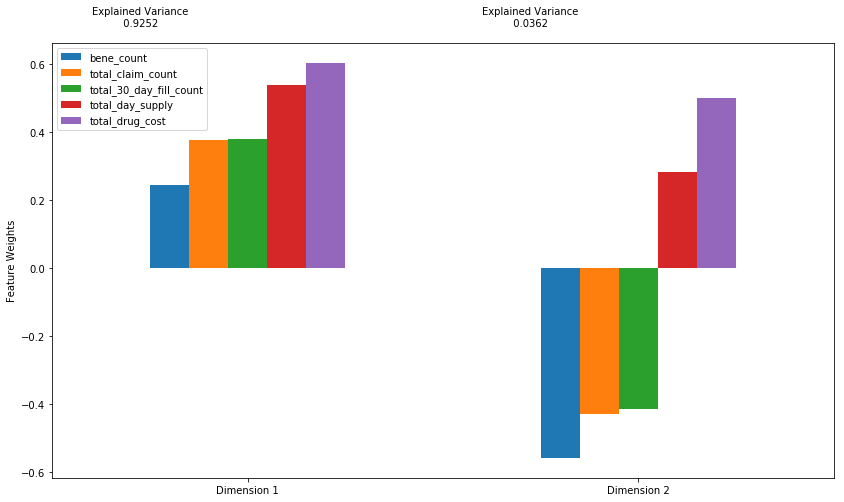

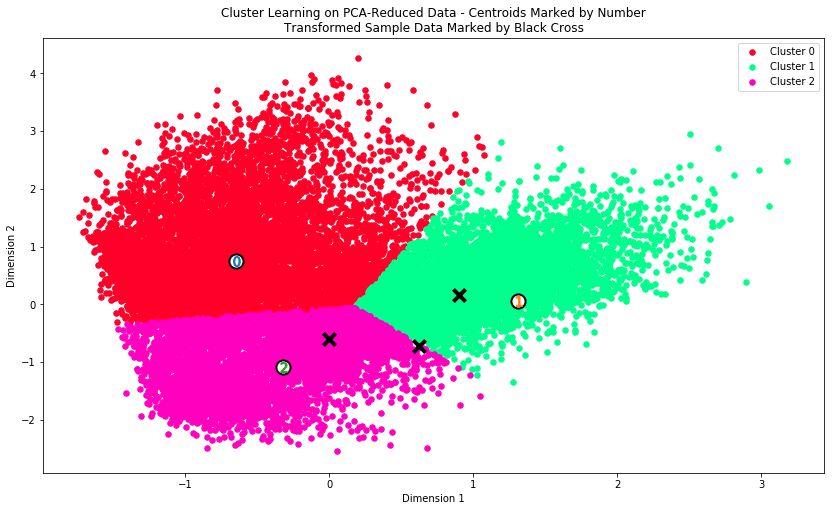

In [46]:
#Data Preprocessing
data_log_PA = np.log(data_grouped_PA)
samples_log_PA = np.log(samples_PA)

#Feature Transformation
# Apply PCA by fitting the data with only two dimensions
pca_PA = PCA(n_components=2, whiten=True).fit(data_log_PA)

# Transform the data using the PCA fit above
pca_data_PA = pca.transform(data_log_PA)
samples_data_pca = pca.transform(samples_log_PA)

# Create a DataFrame for the reduced data
pca_data_PA = pd.DataFrame(pca_data_PA, columns = ['Dimension 1', 'Dimension 2'])

# Generate PCA results plot
pca_results = vs.pca_results(data_log_PA, pca_PA)

#use the cluster to get the labels for PA data
preds_PA = clusterer.predict(pca_data_PA)

#please note that these ceters are from the old model where we fit the data for AL
centers_PA = clusterer.cluster_centers_

# Display the results of the clustering from implementation
vs.cluster_results(pca_data_PA, preds_PA, centers_PA, samples_data_pca)

In [47]:
data_grouped_PA['label']=preds_PA

In [48]:
data_grouped_PA.groupby(['label']).size().sort_values()

label
2    5497
1    6044
0    7734
dtype: int64

In [49]:
data_grouped_PA.groupby(['label']).sum()

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
label,,,,,
0,125202.0,387967.0,389049.5,2562079.0,4.478846e+06
1,296110.0,2627118.0,2704934.9,61929841.0,1.824602e+08
2,49480.0,243538.0,256877.0,5523164.0,7.598314e+06


so for the PA providers we have to take cluster 1 for further investigation

## Data Recovery

In [50]:
# Inverse transform the cente
data_pca_inversetransform = pca.inverse_transform(pca_data)

In [51]:
pca_samples = pd.DataFrame(pca_samples, columns = ['Dimension 1', 'Dimension 2'])
sample_pca_inversetransform = pca.inverse_transform(pca_samples)

In [52]:
# recollect we have take natural log of the values for feature scaling, so apply e to the power 
data_exp = np.exp(data_pca_inversetransform)
samples_exp = np.exp(sample_pca_inversetransform)

In [53]:
data_exp

array([[    5.08226904,    22.69461549,    23.17992304,   175.10873743,
          159.88075671],
       [    6.74859827,    23.84611602,    23.86208682,   103.90626842,
          140.66245562],
       [    9.39009462,    62.36855227,    63.70244556,   580.1707281 ,
          614.86943248],
       ..., 
       [   12.88292149,    66.19278366,    66.09513648,   327.79495896,
          537.18608223],
       [    5.19205912,    46.47602473,    49.08482275,  1056.4457898 ,
          570.360915  ],
       [    3.57876196,    22.05433728,    23.14109723,   363.17934037,
          198.6227154 ]])

In [54]:
samples_exp

array([[  2.70803027e+02,   2.28648956e+04,   2.37803771e+04,
          1.05805194e+06,   1.90418157e+06],
       [  3.67408717e+02,   2.15025816e+04,   2.17531655e+04,
          4.49135588e+05,   1.35010941e+06],
       [  7.67255790e+00,   1.15906272e+01,   1.10794009e+01,
          1.20800682e+01,   3.48717202e+01]])

In [55]:
# too many float values, let us try to round it off
data_actual_aggri_by_npi = pd.DataFrame(np.round(data_exp), columns = data_log.keys())
samples_actual_aggri_by_npi = pd.DataFrame(np.round(samples_exp), columns = samples_log.keys())

In [56]:
data_actual_aggri_by_npi.index=data_log.index
samples_actual_aggri_by_npi.index=samples_log.index

In [57]:
data_actual_aggri_by_npi.head(5)

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
npi,,,,,
1003011859,5.0,23.0,23.0,175.0,160.0
1003014762,7.0,24.0,24.0,104.0,141.0
1003024746,9.0,62.0,64.0,580.0,615.0
1003086521,25.0,336.0,345.0,4728.0,6004.0
1003100694,6.0,57.0,60.0,1212.0,727.0


In [58]:
# execute to see the variance in data that the principal components do not capture
# notice how the original data and the recovered data differ
data_aggr_npi.head(5)

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
npi,,,,,
1003011859,5.0,21.0,21.0,163.0,195.97
1003014762,5.0,29.0,29.0,92.0,134.03
1003024746,10.0,55.0,55.0,559.0,757.78
1003086521,30.0,291.0,306.7,5048.0,6341.76
1003100694,5.0,97.0,97.0,1414.0,329.56


In [59]:
samples_actual_aggri_by_npi

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
npi,,,,,
1053372201,271.0,22865.0,23780.0,1058052.0,1904182.0
1023079274,367.0,21503.0,21753.0,449136.0,1350109.0
1417967688,8.0,12.0,11.0,12.0,35.0


In [60]:
samples

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
npi,,,,,
1053372201,149.0,19905.0,20061.8,579336.0,5385210.27
1023079274,457.0,13659.0,13741.4,398378.0,2698514.25
1417967688,11.0,11.0,11.0,16.0,24.10


##### Here I am assuming that sklearn would preserve the order of data, meaning row 1 in original data is transformed to row 1 in pca data, with that assumption I will assign the preds on pca_data to data_aggr_npi

In [61]:
data_aggr_npi['label']=preds

In [62]:
data_aggr_npi.groupby(['label']).size().sort_values()

label
1    1892
2    2038
0    2812
dtype: int64

In [63]:
data_aggr_npi.groupby(['label']).sum()

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
label,,,,,
0,37074.0,190779.0,191032.7,982166.0,1480624.12
1,85962.0,1846135.0,1894610.3,46419323.0,87488960.36
2,16061.0,148018.0,156735.2,3310452.0,2175316.59


Looking at the data one can notice that total_drug_cost for cluster 1 is huge when compared to other clusters. I will pick cluster 1 for further investigation

If we recollect I have taken 2 fraudulent providers as, recollect their NPI are 1053372201,1023079274 and in addition to that we have taken an NPI who has the least total drug cost that is 1417967688. Now let us which cluster all three fall into. From the clustering graph i am confident that they fall in to cluster 1.

In [64]:
data_aggr_npi.loc[[1053372201,1023079274,1417967688]]

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,label
npi,,,,,,
1053372201,149.0,19905.0,20061.8,579336.0,5385210.27,1
1023079274,457.0,13659.0,13741.4,398378.0,2698514.25,1
1417967688,11.0,11.0,11.0,16.0,24.10,0


In [65]:
clustered_AL = data_aggr_npi.groupby(['label']).sum()
clustered_PA = data_grouped_PA.groupby(['label']).sum()

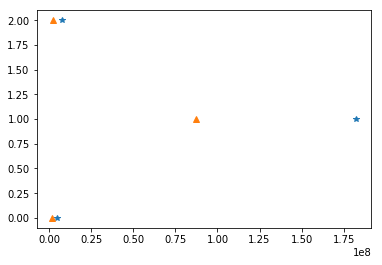

In [66]:
plt.plot(clustered_PA['total_drug_cost'], clustered_PA.index,'*',
        clustered_AL['total_drug_cost'], clustered_AL.index,'^')

#### Now let us try to compare clustered data to the exclusion list

In [67]:
data_exclusionlist = pd.read_csv('05_2018_OIG_ExclusionList.csv')

/ML_Anaconda/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [68]:
data_aggr_npi['exclusion'] = ''
#data_aggr_npi = data_aggr_npi.drop(['exclusion'],axis=1)

In [69]:
data_aggr_npi.head(5)

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,label,exclusion
npi,,,,,,,
1003011859,5.0,21.0,21.0,163.0,195.97,2,
1003014762,5.0,29.0,29.0,92.0,134.03,0,
1003024746,10.0,55.0,55.0,559.0,757.78,0,
1003086521,30.0,291.0,306.7,5048.0,6341.76,1,
1003100694,5.0,97.0,97.0,1414.0,329.56,2,


In [70]:
# we will notice some of the values in the NPI column are 0, which we cannot use, so we exclude that data
for i in data_exclusionlist[(data_exclusionlist['NPI']!=0)]['NPI']:
    if i in data_aggr_npi.index:
        data_aggr_npi.loc[i,'exclusion'] = 1

In [71]:
# the following records should be listed in cluster 1 for further investigation but they are not
data_aggr_npi[(data_aggr_npi['label']!=1)&(data_aggr_npi['exclusion']==1)]

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,label,exclusion
npi,,,,,,,
1013018977,15.0,204.0,208.3,6003.0,5429.11,2,1
1104941137,5.0,44.0,44.0,145.0,229.58,0,1
1467400028,10.0,77.0,77.7,2138.0,3529.46,2,1
1558445999,5.0,39.0,39.0,120.0,196.44,0,1
1881736346,10.0,82.0,82.2,2102.0,1989.76,2,1
1962511915,5.0,25.0,25.0,697.0,267.75,2,1


In [72]:
# the following records should be listed in cluster 1 for further investigation and they are
data_aggr_npi[(data_aggr_npi['label']==1)&(data_aggr_npi['exclusion']==1)]

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,label,exclusion
npi,,,,,,,
1023079274,457.0,13659.0,13741.4,398378.0,2698514.25,1,1
1053372201,149.0,19905.0,20061.8,579336.0,5385210.27,1,1
1124016480,40.0,858.0,881.0,23988.0,79414.55,1,1
1154337129,72.0,918.0,947.5,24788.0,24055.70,1,1
1225011612,20.0,801.0,803.5,10522.0,10054.91,1,1
1235145335,60.0,408.0,410.6,11232.0,70568.50,1,1
1245279645,35.0,526.0,535.5,14679.0,33359.11,1,1
1336107184,30.0,2174.0,2181.3,63948.0,59605.83,1,1
1417938663,20.0,156.0,156.0,2594.0,1932.77,1,1


So out of the 18 providers from the exclusion list that are present in our AL opioid data we were able to identify 12 providers for further investigation. So for the cluster 1 we have total 1892 providers for investigation, out of which in real world if we were to investigate we will end up finding 12 providers as fradulent. 12 out of 1892 is kind of small number to investigate 1892 providers and find these 12 is tesdious. Please do note that rather than investigation ~10000 providers(https://www.aamc.org/download/447144/data/alabamaprofile.pdf) in the state of Alabama it is better that we narrow down the scope and look into 1892 providers. If we have more features we can use those features to further narrow down the list, the NPI exclusion list is not a good soource of data, a quick look at the data shows that lot of values are blank.

We can use this newly labeled data an input to classification problem. Use the Classification model to predict the labels for rest of the opioid claims data

I will conclude the capstone project here.